In [1]:
import numpy as np
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [2]:
ds_path = "datasets/Intel Image Classification/"
train_path = os.path.join(ds_path, "seg_train")
test_path = os.path.join(ds_path, "seg_test")

classes = os.listdir(train_path)
classes # classes of the dataset

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [3]:
BATCHSIZE = 32
N_WORKERS = 2

In [4]:
# test transformations
test_transform = transforms.Compose([
    transforms.Resize((150, 150)),  
    transforms.ToTensor(),          
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Load full training dataset
full_train_ds = datasets.ImageFolder(root=train_path, transform=test_transform)
test_ds = datasets.ImageFolder(root=test_path, transform=test_transform)
# Randomly split dataset
train_ds, val_ds = random_split(full_train_ds, [0.8, 0.2])

In [5]:
# Create DataLoaders
test_loader = DataLoader(test_ds, batch_size=BATCHSIZE, shuffle=False)
train_loader = DataLoader(train_ds, batch_size=BATCHSIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCHSIZE, shuffle=False)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
def train_model(model, train_loader, val_loader, n_epochs=10, print_progress=True, dynamic_lr=False, scheduler=None):

    train_losses, train_accs, train_f1s = [], [], []
    val_losses, val_accs, val_f1s = [], [], []
    
    for epoch in range(n_epochs):
        ### --- TRAINING PHASE --- ###
        model.train()
        train_loss = 0.0
        y_true_train = np.zeros(len(train_ds), dtype=int)
        y_pred_train = np.zeros(len(train_ds), dtype=int)

        index = 0
        for images, labels in train_loader:
            batch_size = labels.size(0) 
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track statistics
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            y_true_train[index : index + batch_size] = labels.cpu().numpy()
            y_pred_train[index : index + batch_size] = predicted.cpu().numpy()
            index += batch_size
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_f1 = f1_score(y_true_train, y_pred_train, average="weighted")
        
        train_loss = train_loss/len(train_ds)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)
        
        ### --- VALIDATION PHASE --- ###
        model.eval()
        val_loss = 0.0
        y_true_val = np.zeros(len(val_ds), dtype=int)
        y_pred_val = np.zeros(len(val_ds), dtype=int)
        with torch.no_grad():  
            index = 0
            for images, labels in val_loader:
                batch_size = labels.size(0) 
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                y_true_val[index : index + batch_size] = labels.cpu().numpy()
                y_pred_val[index : index + batch_size] = predicted.cpu().numpy()
                index += batch_size

        val_acc = accuracy_score(y_true_val, y_pred_val)
        val_f1 = f1_score(y_true_val, y_pred_val, average="weighted")

        val_loss = val_loss/len(val_ds)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        val_f1s.append(val_f1)

        if dynamic_lr:
            scheduler.step()
            print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")
            
        if print_progress:
            print(f"Epoch [{epoch+1}/{n_epochs}]: "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f} | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
    
    if print_progress:
        print("Training Complete!")
    return train_losses, train_accs, train_f1s, val_losses, val_accs, val_f1s


In [8]:
def visualize_scores(metrics):
    # Unpack metrics
    train_losses, train_accs, train_f1s, val_losses, val_accs, val_f1s = metrics
    epochs = range(1, len(train_losses) + 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot Loss
    axes[0].plot(epochs, train_losses, label="Train Loss")
    axes[0].plot(epochs, val_losses, label="Val Loss")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].grid(visible=True)
    axes[0].legend()

    # Plot Accuracy
    axes[1].plot(epochs, train_accs, label="Train Accuracy")
    axes[1].plot(epochs, val_accs, label="Val Accuracy")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].grid(visible=True)
    axes[1].legend()

    # Plot F1-score
    axes[2].plot(epochs, train_f1s, label="Train F1-score")
    axes[2].plot(epochs, val_f1s, label="Val F1-score")
    axes[2].set_title("F1-score")
    axes[2].set_xlabel("Epochs")
    axes[2].set_ylabel("F1-score")
    axes[2].grid(visible=True)
    axes[2].legend()

    plt.tight_layout()
    plt.show()


In [9]:
def conf_matrices(y_true_train, y_pred_train, y_true_val, y_pred_val, class_names):
    # Compute confusion matrices
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_val = confusion_matrix(y_true_val, y_pred_val)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Train Confusion Matrix
    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_title("Train Confusion Matrix")
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")

    # Plot Validation Confusion Matrix
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_title("Validation Confusion Matrix")
    axes[1].set_xlabel("Predicted Labels")
    axes[1].set_ylabel("True Labels")

    plt.tight_layout()
    plt.show()


In [10]:
def get_predictions(model, dataloader):

    model.eval()  
    y_true = []
    y_pred = []

    with torch.no_grad():  
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)  
            _, predicted = torch.max(outputs, 1)  
            
            y_true.extend(labels.cpu().numpy())  
            y_pred.extend(predicted.cpu().numpy())  

    return np.array(y_true), np.array(y_pred)

In [11]:
def visualize(model, metrics):
        visualize_scores(metrics)
        val_true, val_pred = get_predictions(model, val_loader)
        train_true, train_pred = get_predictions(model, train_loader)
        conf_matrices(train_true, train_pred, val_true, val_pred, classes)

In [12]:
class CNN_3blocks(nn.Module):
    def __init__(self, n_classes=6):
        super(CNN_3blocks, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(256 * 18 * 18, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  

        return x


In [13]:
class CNN_3blocks_dr(nn.Module):
    def __init__(self, n_classes=6):
        super(CNN_3blocks_dr, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.3)

        
        self.fc1 = nn.Linear(256 * 18 * 18, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  

        return x


In [14]:
train_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_ds.dataset = deepcopy(train_ds.dataset)
train_ds.dataset.transform = train_transform

In [15]:
checkpoint = torch.load('models/v4_3.pth', weights_only=False)

In [16]:
metrics_v4_3 = checkpoint['metrics']

In [17]:
model_v4_3dr = CNN_3blocks_dr(6)
model_v4_3dr.load_state_dict(checkpoint['model_state_dict'])
model_v4_3dr.to(device)
criterion = nn.CrossEntropyLoss()

In [18]:
LR = 2e-5
optimizer = torch.optim.Adam(model_v4_3dr.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

In [19]:
%%time 
EPOCHS = 10
metrics_v4_3dr = train_model(model_v4_3dr, train_loader, val_loader, EPOCHS, dynamic_lr=True, scheduler=scheduler)

Current LR: 0.000020
Epoch [1/10]: Train Loss: 0.4013, Train Acc: 0.86 | Val Loss: 0.2864, Val Acc: 0.90
Current LR: 0.000016
Epoch [2/10]: Train Loss: 0.3503, Train Acc: 0.88 | Val Loss: 0.2599, Val Acc: 0.91
Current LR: 0.000016
Epoch [3/10]: Train Loss: 0.3284, Train Acc: 0.88 | Val Loss: 0.2634, Val Acc: 0.91
Current LR: 0.000013
Epoch [4/10]: Train Loss: 0.3148, Train Acc: 0.89 | Val Loss: 0.2627, Val Acc: 0.92
Current LR: 0.000013
Epoch [5/10]: Train Loss: 0.3061, Train Acc: 0.89 | Val Loss: 0.2566, Val Acc: 0.91
Current LR: 0.000010
Epoch [6/10]: Train Loss: 0.2959, Train Acc: 0.90 | Val Loss: 0.2730, Val Acc: 0.91
Current LR: 0.000010
Epoch [7/10]: Train Loss: 0.2872, Train Acc: 0.90 | Val Loss: 0.2578, Val Acc: 0.91
Current LR: 0.000008
Epoch [8/10]: Train Loss: 0.2726, Train Acc: 0.90 | Val Loss: 0.2565, Val Acc: 0.92
Current LR: 0.000008
Epoch [9/10]: Train Loss: 0.2730, Train Acc: 0.90 | Val Loss: 0.2598, Val Acc: 0.91
Current LR: 0.000007
Epoch [10/10]: Train Loss: 0.2674,

In [22]:
metrics_v4_3 = list(metrics_v4_3)
metrics_v4_3dr = list(metrics_v4_3dr)
for i in range(6):
    metrics_v4_3dr[i] = metrics_v4_3[i] + metrics_v4_3dr[i]

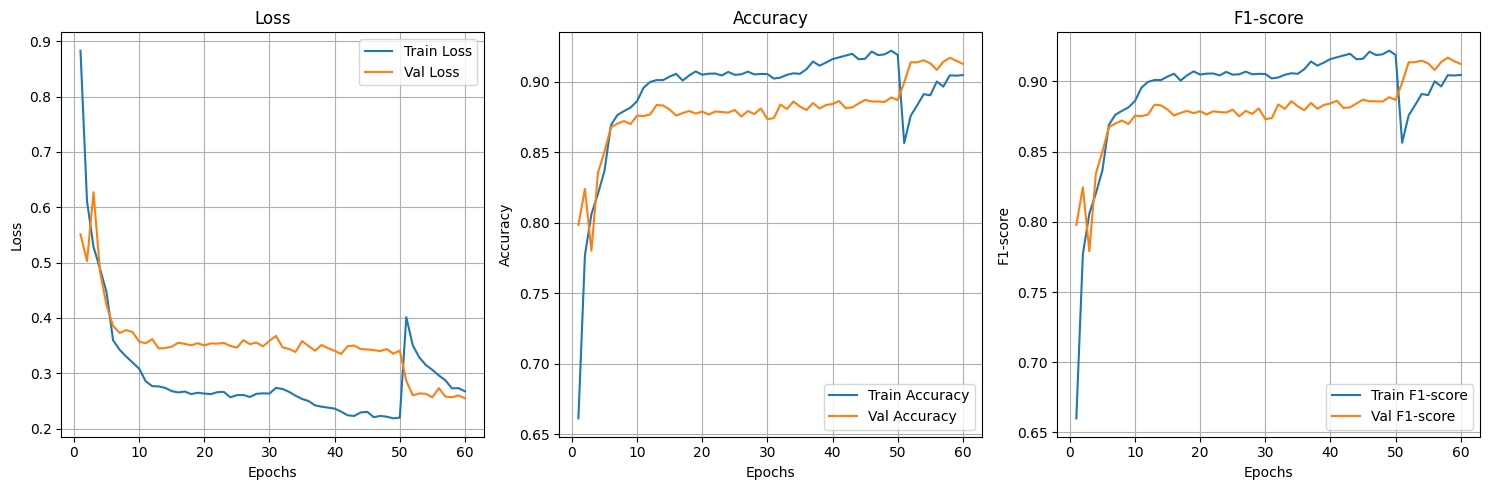

In [23]:
visualize_scores(metrics_v4_3dr)

In [35]:
%%time 
EPOCHS = 20
metrics_cont = train_model(model_v4_3dr, train_loader, val_loader, EPOCHS)

Epoch [1/20]: Train Loss: 0.2545, Train Acc: 0.91 | Val Loss: 0.2624, Val Acc: 0.91
Epoch [2/20]: Train Loss: 0.2535, Train Acc: 0.91 | Val Loss: 0.2588, Val Acc: 0.92
Epoch [3/20]: Train Loss: 0.2457, Train Acc: 0.91 | Val Loss: 0.2644, Val Acc: 0.91
Epoch [4/20]: Train Loss: 0.2505, Train Acc: 0.91 | Val Loss: 0.2605, Val Acc: 0.92
Epoch [5/20]: Train Loss: 0.2394, Train Acc: 0.92 | Val Loss: 0.2586, Val Acc: 0.92
Epoch [6/20]: Train Loss: 0.2379, Train Acc: 0.91 | Val Loss: 0.2666, Val Acc: 0.91
Epoch [7/20]: Train Loss: 0.2309, Train Acc: 0.92 | Val Loss: 0.2541, Val Acc: 0.92
Epoch [8/20]: Train Loss: 0.2396, Train Acc: 0.92 | Val Loss: 0.2598, Val Acc: 0.92
Epoch [9/20]: Train Loss: 0.2307, Train Acc: 0.92 | Val Loss: 0.2679, Val Acc: 0.91
Epoch [10/20]: Train Loss: 0.2278, Train Acc: 0.92 | Val Loss: 0.2600, Val Acc: 0.91
Epoch [11/20]: Train Loss: 0.2229, Train Acc: 0.92 | Val Loss: 0.2695, Val Acc: 0.91
Epoch [12/20]: Train Loss: 0.2256, Train Acc: 0.92 | Val Loss: 0.2608, Val

In [36]:
metrics_cont = list(metrics_cont)
metrics_v4_3dr = list(metrics_v4_3dr)
for i in range(6):
    metrics_v4_3dr[i] = metrics_v4_3dr[i] + metrics_cont[i]

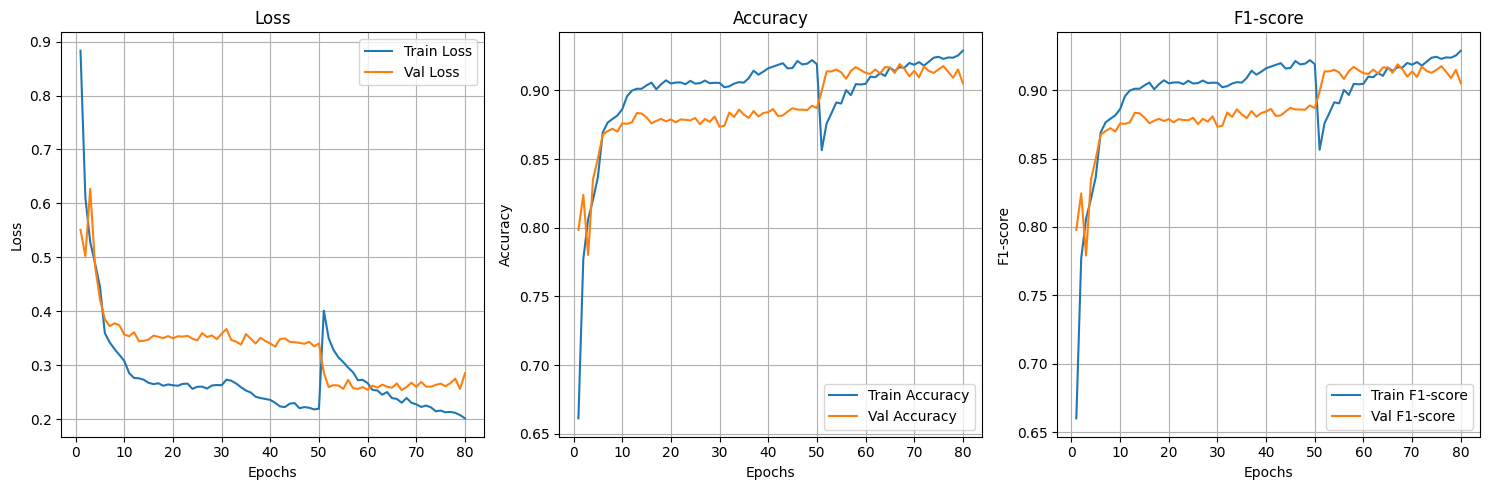

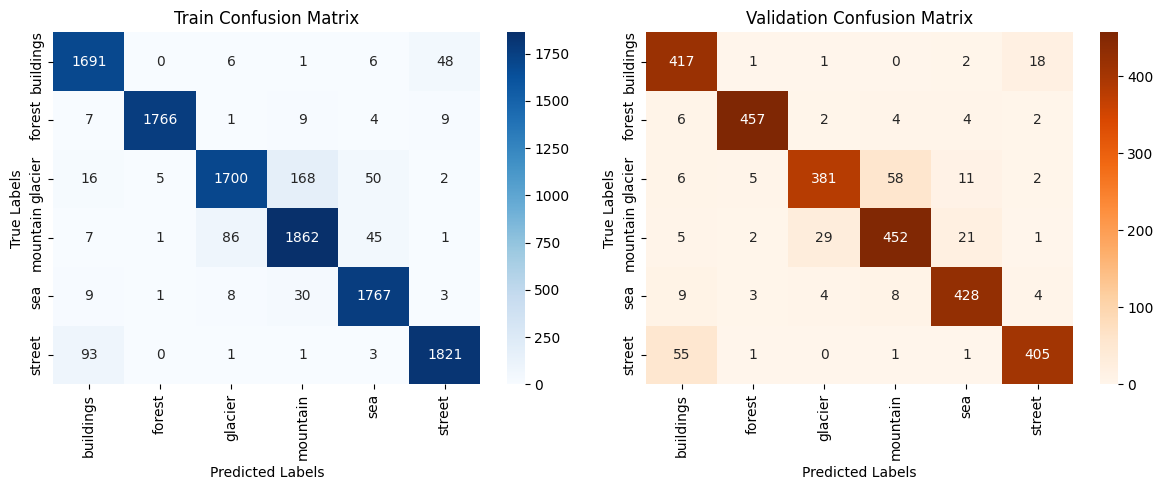

In [39]:
visualize(model_v4_3dr, metrics_v4_3dr)

In [12]:
class CNN_3blocks_dr04(nn.Module):
    def __init__(self, n_classes=6):
        super(CNN_3blocks_dr04, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=0.4)

        
        self.fc1 = nn.Linear(256 * 18 * 18, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  

        return x


In [48]:
chekpoint = torch.load('models/v4_3dr.pth', weights_only=False)

In [51]:
metrics_v4_3dr = chekpoint['metrics']
model_v4_3dr = CNN_3blocks_dr04(6).to(device)
model_v4_3dr.load_state_dict(chekpoint['model_state_dict'])
optimizer = torch.optim.Adam(model_v4_3dr.parameters(), lr=7e-6)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.8)

In [52]:
%%time 
EPOCHS = 10
metrics_cont = train_model(model_v4_3dr, train_loader, val_loader, EPOCHS, dynamic_lr=True, scheduler=scheduler)

Current LR: 0.000007
Epoch [1/10]: Train Loss: 0.2168, Train Acc: 0.92 | Val Loss: 0.2765, Val Acc: 0.91
Current LR: 0.000006
Epoch [2/10]: Train Loss: 0.2129, Train Acc: 0.92 | Val Loss: 0.2726, Val Acc: 0.91
Current LR: 0.000006
Epoch [3/10]: Train Loss: 0.2048, Train Acc: 0.93 | Val Loss: 0.2699, Val Acc: 0.91
Current LR: 0.000004
Epoch [4/10]: Train Loss: 0.2113, Train Acc: 0.92 | Val Loss: 0.2752, Val Acc: 0.91
Current LR: 0.000004
Epoch [5/10]: Train Loss: 0.2019, Train Acc: 0.93 | Val Loss: 0.2713, Val Acc: 0.91
Current LR: 0.000004
Epoch [6/10]: Train Loss: 0.2001, Train Acc: 0.93 | Val Loss: 0.2752, Val Acc: 0.91
Current LR: 0.000004
Epoch [7/10]: Train Loss: 0.2025, Train Acc: 0.93 | Val Loss: 0.2706, Val Acc: 0.92
Current LR: 0.000003
Epoch [8/10]: Train Loss: 0.1982, Train Acc: 0.93 | Val Loss: 0.2710, Val Acc: 0.91
Current LR: 0.000003
Epoch [9/10]: Train Loss: 0.1873, Train Acc: 0.93 | Val Loss: 0.2636, Val Acc: 0.92
Current LR: 0.000002
Epoch [10/10]: Train Loss: 0.1897,

In [53]:
metrics_cont = list(metrics_cont)
metrics_v4_3dr = list(metrics_v4_3dr)
for i in range(6):
    metrics_v4_3dr[i] = metrics_v4_3dr[i] + metrics_cont[i]

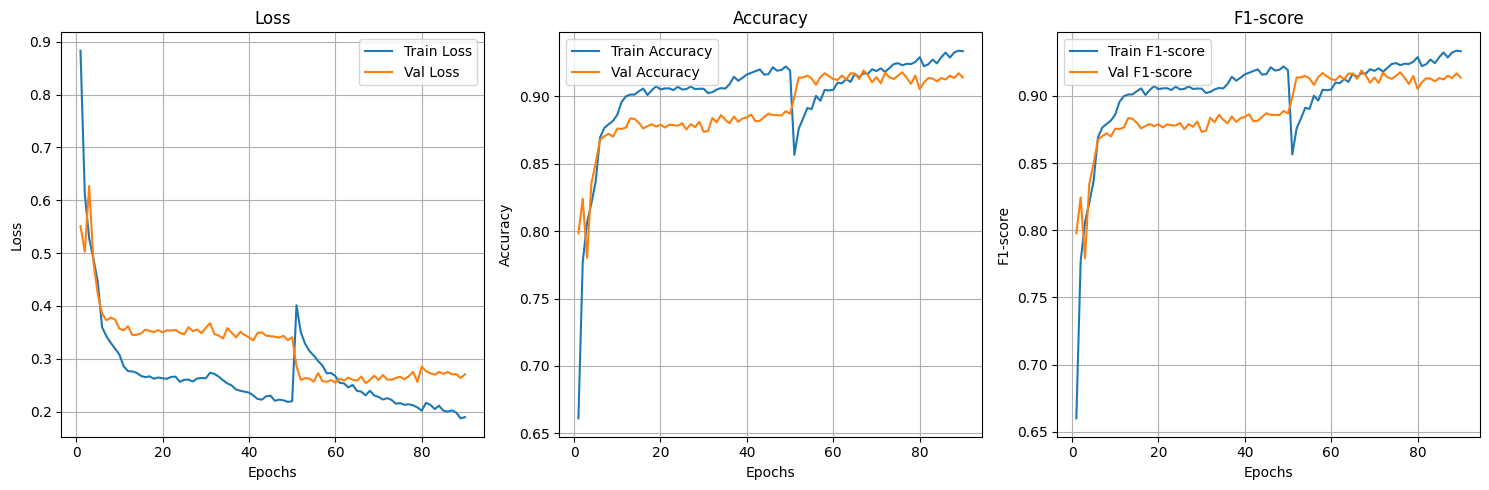

In [54]:
visualize_scores(metrics_v4_3dr)

In [55]:
%%time 
EPOCHS = 30
metrics_cont = train_model(model_v4_3dr, train_loader, val_loader, EPOCHS)

Epoch [1/30]: Train Loss: 0.1893, Train Acc: 0.93 | Val Loss: 0.2669, Val Acc: 0.92
Epoch [2/30]: Train Loss: 0.1886, Train Acc: 0.93 | Val Loss: 0.2654, Val Acc: 0.92
Epoch [3/30]: Train Loss: 0.1905, Train Acc: 0.93 | Val Loss: 0.2620, Val Acc: 0.92
Epoch [4/30]: Train Loss: 0.1829, Train Acc: 0.93 | Val Loss: 0.2712, Val Acc: 0.92
Epoch [5/30]: Train Loss: 0.1878, Train Acc: 0.94 | Val Loss: 0.2660, Val Acc: 0.92
Epoch [6/30]: Train Loss: 0.1835, Train Acc: 0.94 | Val Loss: 0.2702, Val Acc: 0.92
Epoch [7/30]: Train Loss: 0.1800, Train Acc: 0.94 | Val Loss: 0.2667, Val Acc: 0.92
Epoch [8/30]: Train Loss: 0.1827, Train Acc: 0.94 | Val Loss: 0.2685, Val Acc: 0.92
Epoch [9/30]: Train Loss: 0.1855, Train Acc: 0.93 | Val Loss: 0.2647, Val Acc: 0.91
Epoch [10/30]: Train Loss: 0.1841, Train Acc: 0.94 | Val Loss: 0.2650, Val Acc: 0.92
Epoch [11/30]: Train Loss: 0.1839, Train Acc: 0.94 | Val Loss: 0.2753, Val Acc: 0.91
Epoch [12/30]: Train Loss: 0.1769, Train Acc: 0.94 | Val Loss: 0.2677, Val

In [56]:
metrics_cont = list(metrics_cont)
metrics_v4_3dr = list(metrics_v4_3dr)
for i in range(6):
    metrics_v4_3dr[i] = metrics_v4_3dr[i] + metrics_cont[i]

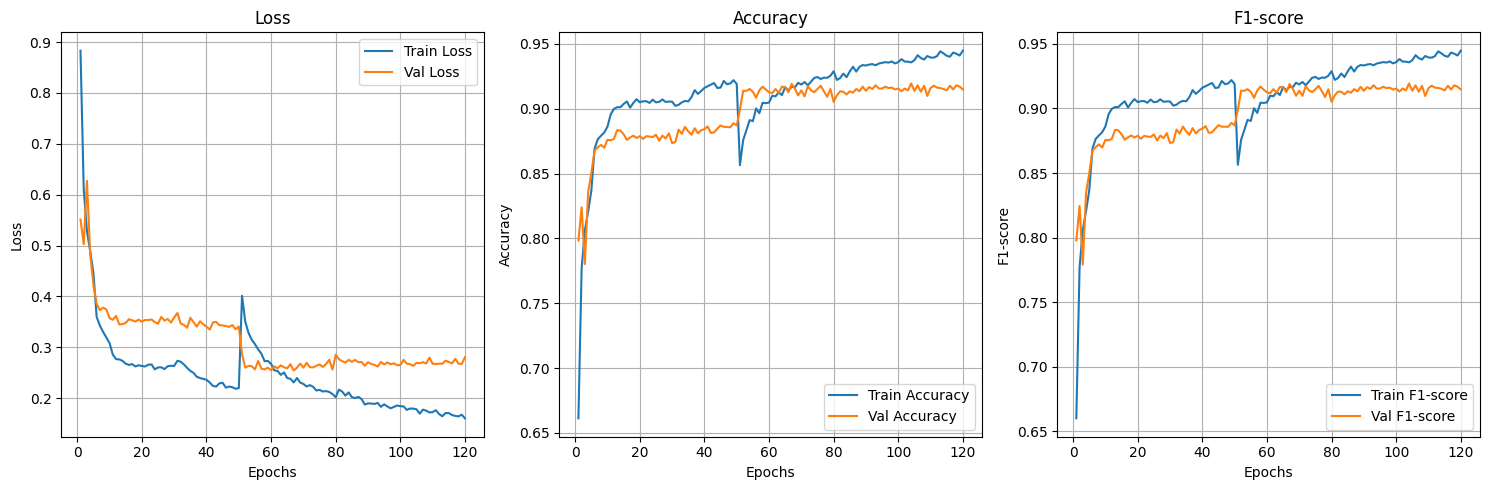

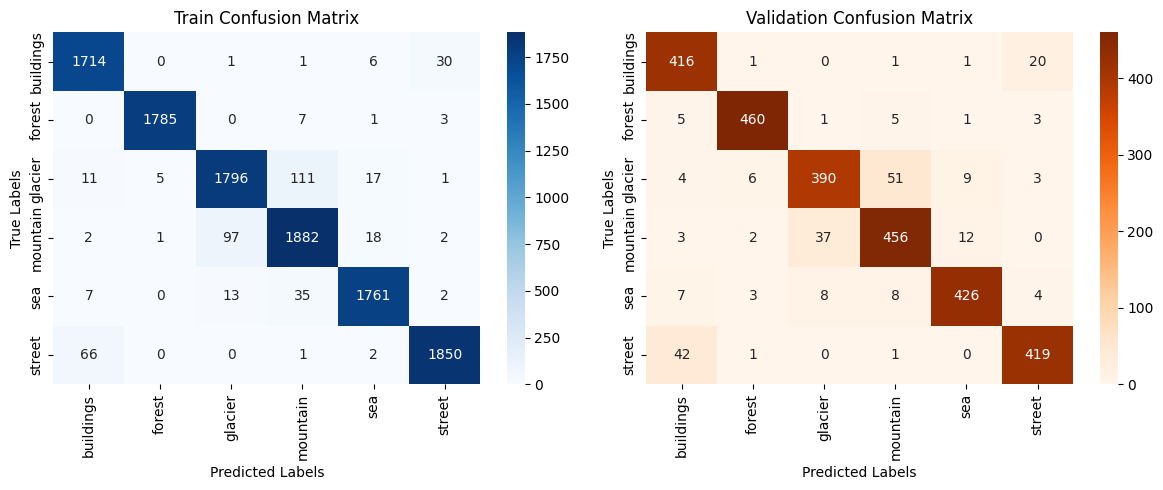

In [59]:
visualize(model_v4_3dr, metrics_v4_3dr)

In [13]:
chekpoint = torch.load('models/v4_3_final.pth', weights_only=False)

In [14]:
model = CNN_3blocks_dr04(6).to(device)
model.load_state_dict(chekpoint['model_state_dict'])

<All keys matched successfully>

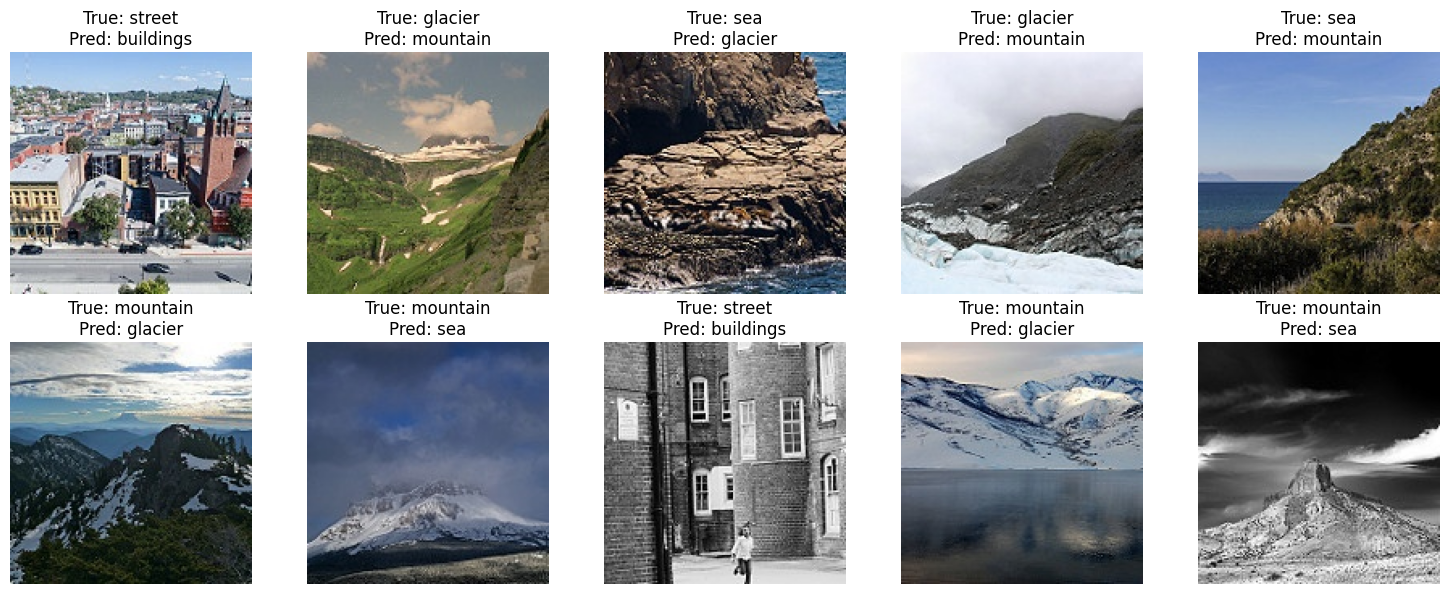

In [30]:
y_true, y_pred = get_predictions(model, val_loader)
n_errors = 10
model.eval()

errors = []
index = 0
with torch.no_grad():
    for images, labels in val_loader:
        batch_size = images.size(0)
        preds = y_pred[index:index + batch_size]
        trues = y_true[index:index + batch_size]

        for i in range(batch_size):
            if preds[i] != trues[i]:
                errors.append((images[i], trues[i], preds[i]))
                if len(errors) >= n_errors:
                    break

        index += batch_size
        if len(errors) >= n_errors:
            break
plt.figure(figsize=(15, 3 * ((n_errors + 4) // 5)))
for i, (img, true_label, pred_label) in enumerate(errors):
    img_vis = img.permute(1, 2, 0).cpu().numpy()
    img_vis = img_vis * 0.5 + 0.5  

    plt.subplot((n_errors + 4) // 5, 5, i+1)
    plt.imshow(img_vis)
    plt.title(f"True: {val_ds.dataset.classes[true_label]}\nPred: {val_ds.dataset.classes[pred_label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()



In [60]:
# torch.save({
#     'model_state_dict': model_v4_3dr.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'metrics': metrics_v4_3dr
# }, 'models/v4_3_final.pth')